In [1]:
# !pip install py-cid
# !pip install py-multihash

## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

from multihash import multihash
from cid import cid

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 15

In [2]:
## Gas per Wasm execution unit
p_op_cost = 4
## Syscall gas
p_syscall_cost = 3500 * p_op_cost
## Extern gas
p_externs_cost = p_syscall_cost * 1.5
## Syscalls that traverse the extern boundary
p_externs_syscalls = 'rand::get_chain_randomness|rand::get_beacon_randomness|ipld::open|crypto::verify_consensus_fault'
## memcpy cost
p_memcpy_per_byte_cost = 0.5
## memory retention cost
p_memret_per_byte_cost = 10

## New IPLD costs are already calculated as part of the syscall and externs cost.
## Unfortunately we are unable to calculate the memcpy costs with the traces we have, but the difference should be negligible.
#p_block_read_cost = 0
#p_block_write_cost = 0
#p_block_link_cost = 0
#p_block_stat_cost = 0

In [3]:
paths = ["timing_detailed_3.log"]
frames = [pd.read_json(path, lines=True) for path in paths]

In [4]:
## concat frames into a single frame
data = pd.concat(frames)

## ops per nanosecond
data['ops_per_ns'] = data['fuel'] / data['wasm_time']

## nanosecond per op
data['ns_per_op'] = 1 / data['ops_per_ns']

## 10 gas = 1 nanosecond
data['gas_per_op'] = data['ns_per_op'] * 10

## filter to only retain message applications
## filter out code == null because it relates to actors that don't exist, or whose creation was reverted
## this is found to happen when sending to a new account address with insufficient funds
## failed to transfer funds (RetCode=6): transfer failed, insufficient balance in sender actor: 14987067394762807013 (RetCode=6)
## example: https://filfox.info/en/message/bafy2bzacedqujzybfhgjglx45y2ek76luwkh5c4yctyaj6h6qayk2vd7z5roo
data = data[data['type'] == 'apply']
data = data.dropna(subset=["code"])

## replace codes with strings
data['code'] = data.code.apply(lambda c: multihash.decode(cid.from_string(c).multihash).digest.decode("utf-8"))

In [5]:
data['new_exec_gas'] = data['fuel'] * p_op_cost
data['new_syscall_gas'] = data['num_syscalls'] * p_syscall_cost
data['new_extern_gas'] = data['num_externs'] * p_externs_cost
data['new_memcpy_gas'] = (data['block_bytes_written'] + data['block_bytes_read']) * p_memcpy_per_byte_cost
data['new_memret_gas'] = data['block_bytes_written'] * p_memret_per_byte_cost
data['new_extra_gas_total'] = data[['new_exec_gas', 'new_syscall_gas', 'new_extern_gas', 'new_memcpy_gas', 'new_memret_gas']].sum(axis=1)
data['new_extra_gas_total'] = data[['new_exec_gas', 'new_syscall_gas', 'new_extern_gas']].sum(axis=1)
data['final_total_gas'] = data['new_extra_gas_total'] + data['gas']
data['new_pct_of_orig_gas'] = (data['new_extra_gas_total'] + data['gas']) / data['gas']

In [6]:
data.drop("epoch", axis=1).groupby(by=["code", "method"]).describe(percentiles=[0.5, 0.99])

fuel                              \
                                   count          mean           std   
code                   method                                          
fil/7/account          0.0       45871.0  1.353791e+03  5.529680e+03   
fil/7/init             2.0           6.0  1.315712e+06  6.092457e+04   
fil/7/multisig         0.0         111.0  0.000000e+00  0.000000e+00   
                       2.0        1837.0  3.380341e+05  3.824969e+05   
                       3.0         467.0  1.688605e+06  1.759338e+06   
                       4.0           1.0  1.036600e+05           NaN   
fil/7/paymentchannel   0.0           1.0  0.000000e+00           NaN   
fil/7/storagemarket    2.0        2586.0  1.945800e+06  7.422431e+04   
                       3.0           1.0  2.547819e+06           NaN   
                       4.0        5265.0  4.130814e+07  4.707735e+07   
fil/7/storageminer     0.0          22.0  0.000000e+00  0.000000e+00   
                       3.0          33.0  1.556448e+05  8.118950e+03   
                       4.0          56.0  1.276158e+05  6.780235e+03   
                       5.0      217040.0  8.735199e+06  2.629344e+07   
                       6.0     1185718.0  1.020457e+07  1.445686e+07   
                       7.0     1053752.0  2.900851e+06  5.582695e+05   
                       8.0          30.0  9.906549e+08  1.418017e+09   
                       9.0         104.0  2.335959e+07  3.333538e+07   
                       11.0       1615.0  5.065008e+07  9.834858e+07   
                       16.0       1310.0  2.637403e+06  2.891984e+05   
                       18.0         18.0  1.276726e+05  7.877498e+03   
                       22.0          2.0  1.176240e+05  1.951615e+02   
                       23.0         37.0  1.229218e+05  3.819603e+03   
                       25.0       7482.0  3.520126e+07  4.439579e+07   
                       26.0       5810.0  1.076800e+08  1.095982e+08   
                       27.0         81.0  1.326209e+07  3.592145e+06   
fil/7/storagepower     2.0          34.0  2.863682e+06  6.876757e+04   
fil/7/verifiedregistry 4.0          11.0  1.318176e+06  7.697970e+04   

                                                                     \
                                      min         50%           99%   
code                   method                                         
fil/7/account          0.0            0.0         0.0  2.393600e+04   
fil/7/init             2.0      1219606.0   1332816.5  1.370283e+06   
fil/7/multisig         0.0            0.0         0.0  0.000000e+00   
                       2.0       168637.0    272920.0  2.478793e+06   
                       3.0        52934.0    712472.0  6.634846e+06   
                       4.0       103660.0    103660.0  1.036600e+05   
fil/7/paymentchannel   0.0            0.0         0.0  0.000000e+00   
fil/7/storagemarket    2.0      1774057.0   1935126.0  2.078316e+06   
                       3.0      2547819.0   2547819.0  2.547819e+06   
                       4.0      7146614.0  29520395.0  2.578075e+08   
fil/7/storageminer     0.0            0.0         0.0  0.000000e+00   
                       3.0       142360.0    153981.0  1.771409e+05   
                       4.0       111922.0    128751.0  1.407435e+05   
                       5.0        76343.0   4525609.0  6.025616e+07   
                       6.0            0.0   4621880.5  8.009515e+07   
                       7.0            0.0   2882896.5  4.268267e+06   
                       8.0      2692751.0   7517278.5  3.448847e+09   
                       9.0      2853521.0  11081841.5  1.950299e+08   
                       11.0      922872.0   8984258.0  4.961129e+08   
                       16.0      128109.0   2649349.0  3.446623e+06   
                       18.0      111294.0    129040.5  1.397048e+05   
                       22.0      117486.0    117624.0  1.177592e+05   
                       23.0 

# CEL

## EDA on distribution of gas multipliers

In [7]:
df = data[['method', 'new_pct_of_orig_gas']] # we're interested in the gas multipliers
df = df[df['method'].isin([6.0, 7.0, 25.0, 26.0])] # for pre/prove sector/batch combinations
## https://github.com/filecoin-project/builtin-actors/blob/master/actors/miner/src/lib.rs
gas_dict = {6.0: 'PreCommitSectorMul', 7.0: 'ProveCommitSectorMul', 
            25.0: 'PreCommitSectorBatchMul', 26.0: 'ProveCommitAggregateMul'}     
df['gas_type'] = df['method'].map(gas_dict)   
df.head()

,method,new_pct_of_orig_gas,gas_type
1,7.0,1.248354,ProveCommitSectorMul
2,7.0,1.246614,ProveCommitSectorMul
4,6.0,2.972455,PreCommitSectorMul
5,6.0,2.960704,PreCommitSectorMul
6,6.0,2.122333,PreCommitSectorMul


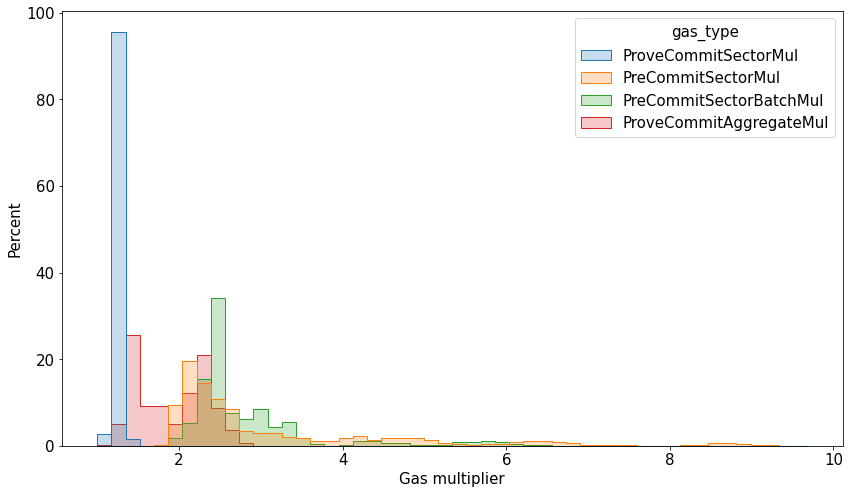

new_pct_of_orig_gas                               \
                                      count  mean   std  min   50%   75%   
gas_type                                                                   
PreCommitSectorBatchMul              7482.0  2.84  0.84  1.0  2.50  3.01   
PreCommitSectorMul                1185718.0  3.12  1.48  1.0  2.48  3.50   
ProveCommitAggregateMul              5810.0  1.91  0.43  1.0  1.91  2.30   
ProveCommitSectorMul              1053752.0  1.25  0.04  1.0  1.25  1.28   

                                     
                          95%   max  
gas_type                             
PreCommitSectorBatchMul  4.97  8.72  
PreCommitSectorMul       6.48  9.68  
ProveCommitAggregateMul  2.55  3.13  
ProveCommitSectorMul     1.32  3.01

In [8]:
# Examine dispersion associated with each multiplier
plt.rcParams['figure.figsize'] = (14.0, 8.0)
sns.histplot(data=df, x="new_pct_of_orig_gas", hue="gas_type", element="step", bins=50, 
             stat="percent", common_norm=False)
plt.xlabel("Gas multiplier")
plt.show()
df.drop('method', axis=1).groupby(by=["gas_type"]).describe(percentiles=[0.75, 0.95]).round(2)

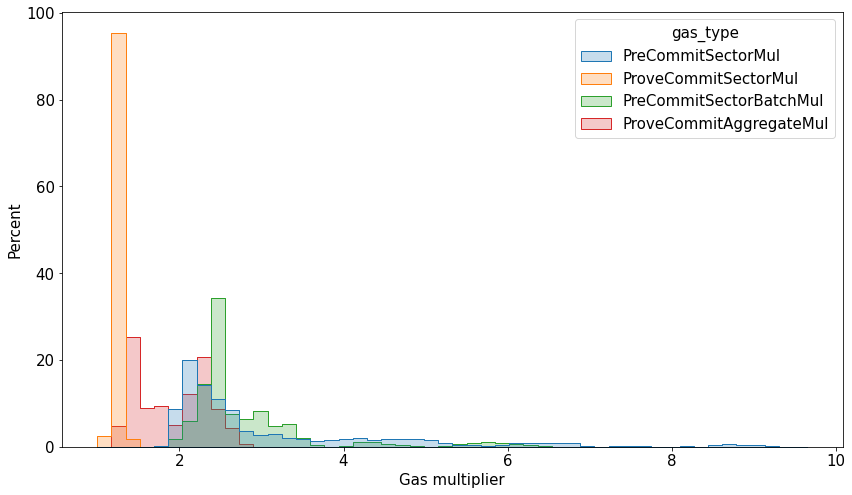

new_pct_of_orig_gas                                \
                                      count  mean   std   min   50%   75%   
gas_type                                                                    
PreCommitSectorBatchMul              5000.0  2.84  0.84  1.00  2.50  3.01   
PreCommitSectorMul                   5000.0  3.13  1.49  1.49  2.49  3.54   
ProveCommitAggregateMul              5000.0  1.91  0.43  1.00  1.92  2.30   
ProveCommitSectorMul                 5000.0  1.25  0.04  1.12  1.25  1.28   

                                     
                          95%   max  
gas_type                             
PreCommitSectorBatchMul  4.91  8.72  
PreCommitSectorMul       6.46  9.65  
ProveCommitAggregateMul  2.56  3.12  
ProveCommitSectorMul     1.32  1.62

In [9]:
# We can reproduce this distribution with fewer
# configurations, e.g. here is for 5000:
dfs = df.groupby('method').sample(n=5000).drop('method', axis=1)
sns.histplot(data=dfs, x="new_pct_of_orig_gas", hue="gas_type", element="step", bins=50, 
             stat="percent", common_norm=False)
plt.xlabel("Gas multiplier")
plt.show()
dfs.groupby(by=["gas_type"]).describe(percentiles=[0.75, 0.95]).round(2)

In [11]:
# Use these 5000 configurations to assess what the economics
# may look like post-FIP-0032 implementation
multipliers_df = pd.DataFrame(columns = gas_dict.values(), 
    data = np.vstack([dfs[dfs['gas_type'] == i]['new_pct_of_orig_gas'].values for i in gas_dict.values()]).T)
multipliers_df.head()

,PreCommitSectorMul,ProveCommitSectorMul,PreCommitSectorBatchMul,ProveCommitAggregateMul
0,1.906029,1.202201,3.329342,1.686960
1,4.610685,1.235469,2.431090,2.553137
2,2.626555,1.238972,3.413166,2.538147
3,2.407896,1.292090,2.476596,1.767764
4,6.195153,1.338409,2.473160,2.350008


## Batching crossover analysis under FIP-0032 gas changes

In [12]:
# Crossover characterises the boundary where rational
# choices to batch or submit single proofs are in
# equilibrium

In [13]:
# Earlier work characterised gas usage vs agg level.
# We'll build on this assuming a 25% split between
# pre and prove sector commit gas usage
gas_usage_df = pd.DataFrame({"aggregation": [1, 13, 26, 51, 102, 205, 410, 819],
                            "gas_usage": [65_733_296.73, 191_086_579, 218_445_690, 26_4473_803,
                                          351_174_896, 518_545_043, 839_487_002, 1_471_318_655]})
gas_usage_df['gas_usage_pre'] = 0.25 * gas_usage_df['gas_usage']
gas_usage_df['gas_usage_prove'] = 0.75 * gas_usage_df['gas_usage']
gas_usage_df.head()

,aggregation,gas_usage,gas_usage_pre,gas_usage_prove
0,1,6.573330e+07,1.643332e+07,4.929997e+07
1,13,1.910866e+08,4.777164e+07,1.433149e+08
2,26,2.184457e+08,5.461142e+07,1.638343e+08
3,51,2.644738e+08,6.611845e+07,1.983554e+08
4,102,3.511749e+08,8.779372e+07,2.633812e+08


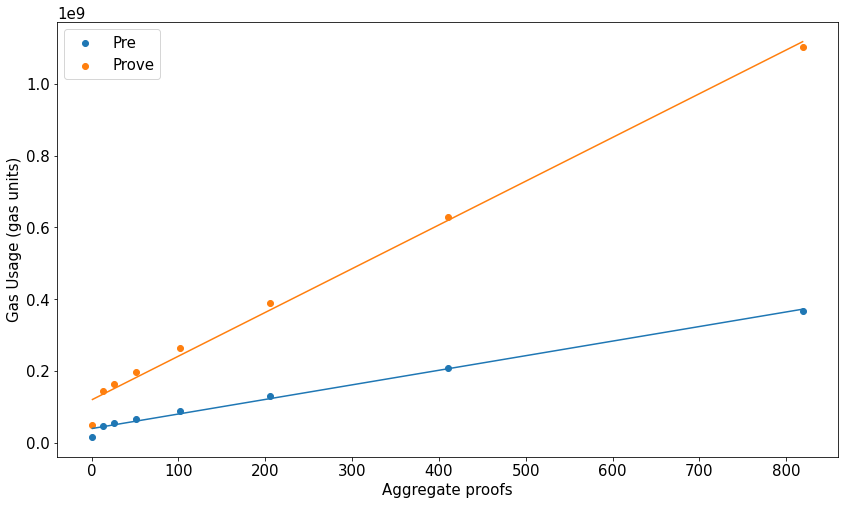

In [14]:
# To have a model of gas usage in terms of 
# aggregation continuously, we fit a linear 
# regression model. Other choices possible

reg_pre = linear_model.LinearRegression()
reg_pre.fit(gas_usage_df['aggregation'].values.reshape(8, 1), gas_usage_df['gas_usage_pre'].values)

reg_prove = linear_model.LinearRegression()
reg_prove.fit(gas_usage_df['aggregation'].values.reshape(8, 1), gas_usage_df['gas_usage_prove'].values)

n_proof_vals = np.linspace(1,819,819).reshape(-1,1)
pre_pred = reg_pre.predict(n_proof_vals)
prove_pred = reg_prove.predict(n_proof_vals)

plt.scatter(gas_usage_df['aggregation'], gas_usage_df['gas_usage_pre'], label="Pre")
plt.plot(n_proof_vals, pre_pred)
plt.scatter(gas_usage_df['aggregation'], gas_usage_df['gas_usage_prove'], label="Prove")
plt.plot(n_proof_vals, prove_pred)
plt.xlabel("Aggregate proofs")
plt.ylabel("Gas Usage (gas units)")
plt.legend()
plt.show()

In [15]:
BATCHDISCOUNT = 0.05 # current value from specification
BATCHBALANCER = 5 # current value from specification

# If gas usage is linear in aggregation there's a closed form 
# solution for the breakeven number of proofs at a given
# level of basefeee

a_pre, b_pre = reg_pre.intercept_, reg_pre.coef_[0] # precommit regression coefs
a_prove, b_prove = reg_prove.intercept_, reg_prove.coef_[0] # provecommit regression coefs
gas_usage_pre_commit_sector = gas_usage_df['gas_usage_pre'].iloc[0] # single sector usage
gas_usage_prove_commit_sector = gas_usage_df['gas_usage_prove'].iloc[0] # single sector usage

def breakeven_n_proofs(multipliers, basefee):
    
    # multiplers = 1,1,1,1 now, or >1,>1,>1,>1 post-FIP-0032 implementation
    pre_sector_mul, prove_sector_mul, pre_batch_mul, prove_batch_mul = multipliers
    
    top = -(a_pre * pre_batch_mul + a_prove * prove_batch_mul) * basefee
    bottom = (basefee * (b_pre * pre_batch_mul + b_prove * prove_batch_mul
                         - gas_usage_pre_commit_sector * pre_sector_mul 
                         - gas_usage_prove_commit_sector * prove_sector_mul) 
              + BATCHDISCOUNT * (gas_usage_pre_commit_sector * pre_sector_mul 
                                 + gas_usage_prove_commit_sector * prove_sector_mul) 
              * max(basefee, BATCHBALANCER))
    
    return top / bottom

# current breakeven number of proofs at basefee = 0.32:
round(breakeven_n_proofs([1, 1, 1, 1], 0.32),0)

13.0

In [20]:
# find the breakeven number of proofs over configurations of 
# sampled commit multipler states supplied from the backtest
breakeven_proofs_at_basefee  = lambda bf: list(map(lambda x: breakeven_n_proofs(x, bf), 
                                                   np.array(multipliers_df)))
breakeven_proofs_at_basefee_now  = lambda bf: breakeven_n_proofs([1, 1, 1, 1], bf)

basefees = np.linspace(0.27,0.5)
breakeven_proofs_now = [breakeven_proofs_at_basefee_now(bf) for bf in basefees]
breakeven_proofs_med = [np.median(breakeven_proofs_at_basefee(bf)) for bf in basefees]
breakeven_proofs_q10 = [np.quantile(breakeven_proofs_at_basefee(bf),0.1) for bf in basefees]
breakeven_proofs_q90 = [np.quantile(breakeven_proofs_at_basefee(bf),0.9) for bf in basefees]
breakeven_proofs_q25 = [np.quantile(breakeven_proofs_at_basefee(bf),0.25) for bf in basefees]
breakeven_proofs_q75 = [np.quantile(breakeven_proofs_at_basefee(bf),0.75) for bf in basefees]

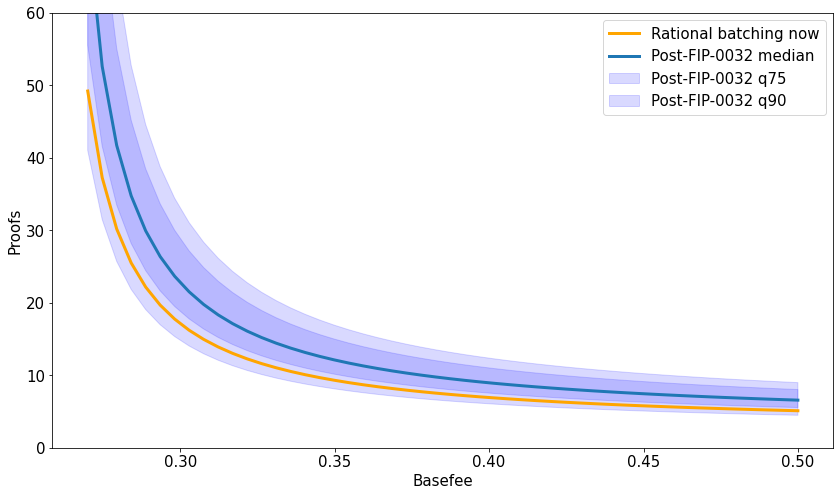

In [21]:
# Current rational batch curve: above this SPs should 
# batch, below it not batch.
# And rational batching curve sampling backtest gas multipliers

plt.plot(basefees, breakeven_proofs_now, color='orange',lw=3, label="Rational batching now")
plt.plot(basefees, breakeven_proofs_med,lw=3, label="Post-FIP-0032 median")
plt.fill_between(basefees, breakeven_proofs_q25, breakeven_proofs_q75, 
                 color='blue', alpha=0.15, label="Post-FIP-0032 q75")
plt.fill_between(basefees, breakeven_proofs_q10, breakeven_proofs_q90, 
                 color='blue', alpha=0.15, label="Post-FIP-0032 q90")

plt.ylabel('Proofs')
plt.xlabel('Basefee')
plt.ylim(0,60)
plt.legend()
plt.show()

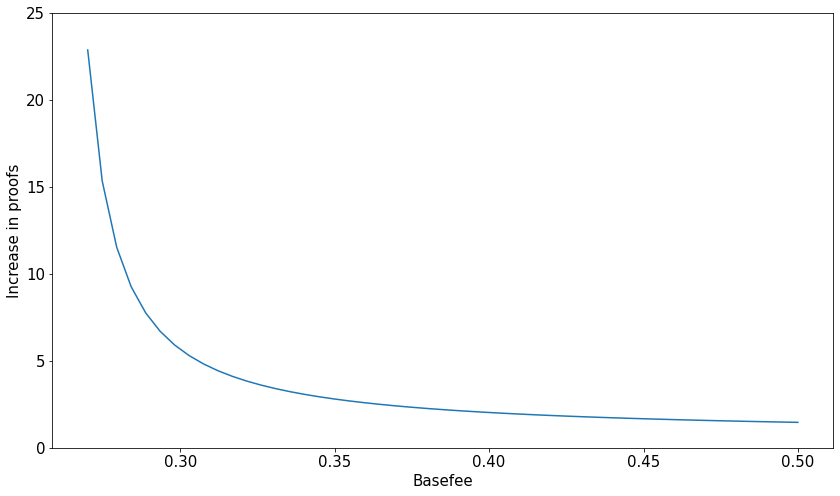

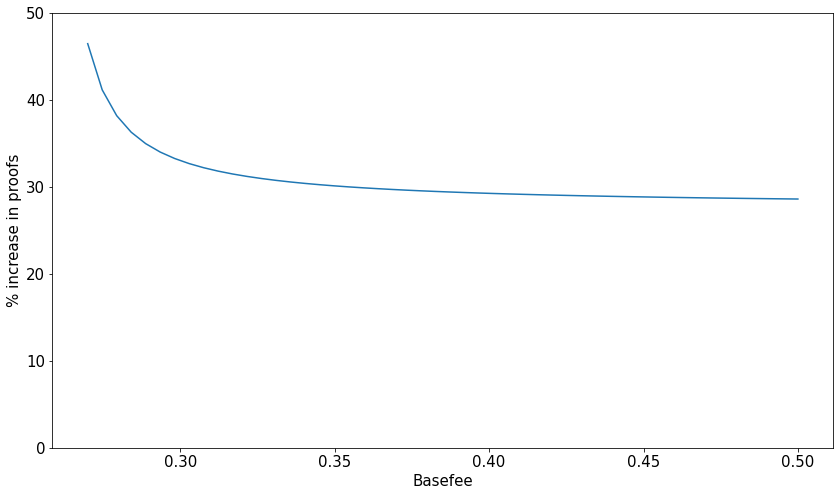

In [22]:
# How much is the increase in crossover proofs 
# post-FIP-0032 implementation?

plt.plot(basefees, (np.array(breakeven_proofs_med)-np.array(breakeven_proofs_now)))
plt.ylabel('Increase in proofs')
plt.xlabel('Basefee')
plt.ylim(0,25)
plt.show()

plt.plot(basefees, 100 * (np.array(breakeven_proofs_med)-
                          np.array(breakeven_proofs_now)) / np.array(breakeven_proofs_now))
plt.ylabel('% increase in proofs')
plt.xlabel('Basefee')
plt.ylim(0,50)
plt.show()

In [23]:
# Break even number of proofs at current basefee now and post-FVM
CURRENT_BASEFEE = 0.32 # 
round(np.median(breakeven_proofs_at_basefee(CURRENT_BASEFEE)),2), np.round(breakeven_proofs_at_basefee_now(CURRENT_BASEFEE),2)

(16.44, 12.52)

In [24]:
# Increase
round(np.median(breakeven_proofs_at_basefee(CURRENT_BASEFEE)) - breakeven_proofs_at_basefee_now(CURRENT_BASEFEE),2)

3.92

In [25]:
# % increase
round(100 * (np.median(breakeven_proofs_at_basefee(CURRENT_BASEFEE)) - 
             breakeven_proofs_at_basefee_now(CURRENT_BASEFEE)) / 
      breakeven_proofs_at_basefee_now(CURRENT_BASEFEE),1)

31.3

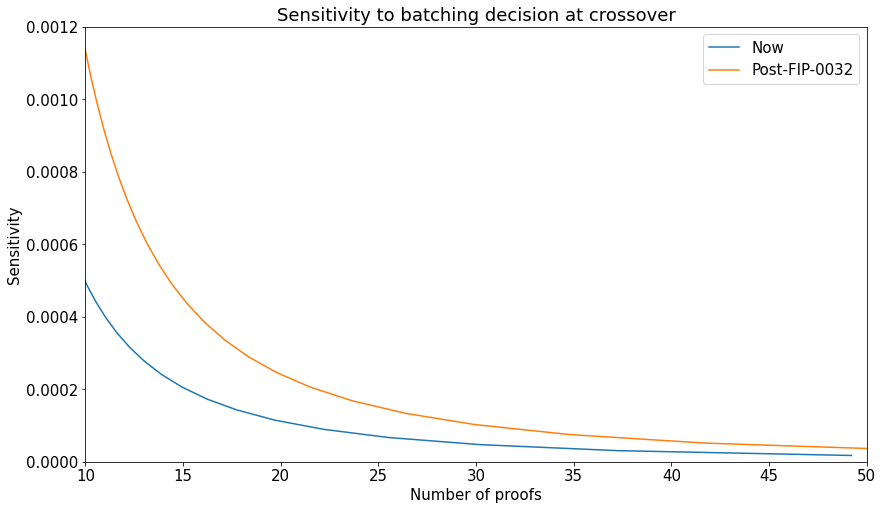

In [26]:
# Let's estimate the sensitivity of the decision now compared
# to post-FIP-0032 by comparing the absolute cost gradient
# at the crossover boundary.

# Larger number will mean more sensitivity to making the correct
# decision, or higher cost for getting it wrong

def batching_unit_network_fee(multipliers, basefee, n_proofs):
    
    # multiplers = 1,1,1,1 now, or >1,>1,>1,>1 post-FIP-0032
    pre_sector_mul, prove_sector_mul, pre_batch_mul, prove_batch_mul = multipliers
    
    gas_fee = (basefee * ((a_pre + b_pre*n_proofs)*pre_batch_mul 
                         + (a_prove + b_prove*n_proofs)*prove_batch_mul)) / n_proofs
    batch_charge = (BATCHDISCOUNT * (gas_usage_pre_commit_sector * pre_sector_mul 
                                    + gas_usage_prove_commit_sector * prove_sector_mul) 
                    * max(basefee, BATCHBALANCER))
    
    return (gas_fee + batch_charge) * 10**-9

def sector_unit_network_fee(multipliers, basefee):
    
    # multiplers = 1,1,1,1 now, or >1,>1,>1,>1 post-FIP-0032
    pre_sector_mul, prove_sector_mul, pre_batch_mul, prove_batch_mul = multipliers
    
    gas_fee = basefee * (gas_usage_pre_commit_sector * pre_sector_mul 
                         + gas_usage_prove_commit_sector * prove_sector_mul) 
    
    return gas_fee * 10**-9

def batch_diff(basefee, n_proofs, multipler):
    return sector_unit_network_fee(multipler, basefee) - batching_unit_network_fee(multipler, basefee, n_proofs)

def batch_diff_grad_abs(basefee, n_proofs, multipler):
    return np.abs(batch_diff(basefee, n_proofs+1, multipler) - batch_diff(basefee, n_proofs, multipler))

point_est_mul = multipliers_df.median().values
sensitivity_at_boundary_now = [batch_diff_grad_abs(bf,n_proof, [1,1,1,1]) 
                           for bf, n_proof in zip(basefees, breakeven_proofs_now)]
sensitivity_at_boundary_postfip0032 = [batch_diff_grad_abs(bf, n_proof, point_est_mul) 
                           for bf, n_proof in zip(basefees, breakeven_proofs_med)]

plt.plot(breakeven_proofs_now,sensitivity_at_boundary_now, label="Now")
plt.plot(breakeven_proofs_med,sensitivity_at_boundary_postfip0032, label="Post-FIP-0032")
plt.ylabel('Sensitivity')
plt.xlabel('Number of proofs')
plt.title("Sensitivity to batching decision at crossover")
plt.xlim(10,50)
plt.ylim(0,0.0012)
plt.legend()
plt.show()

## Should there be a parameter change to the batch balancer?

#### 1. Estimate crossover number of proofs and new batch balancer using a *derived* network basefee based on network growth assumptions and assumptions of how gas usage should be valued

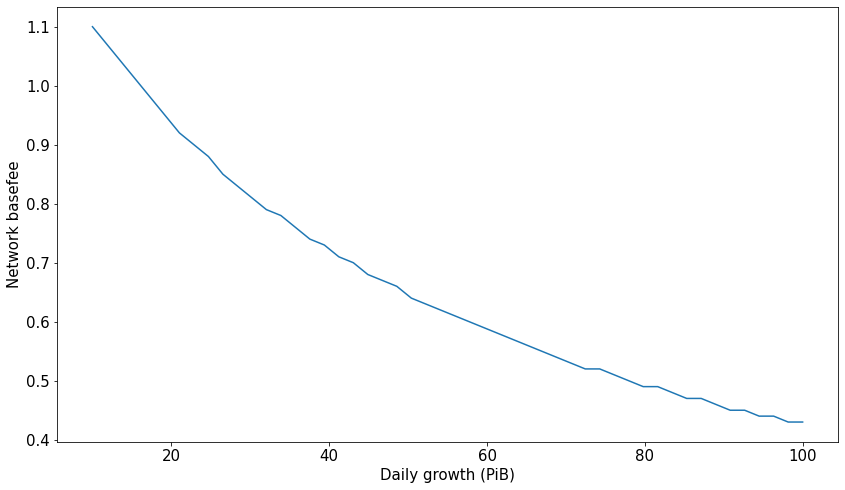

Derived network basefee: 0.43


In [27]:
# First identify an incentive-aligned network basefee based on
# desirable but still plausible assumptions of network growth

CURRENT_NETWORK_POWER_PIB = 16995.96728528195
DAILY_POWER_GROWTH_PIB = 100
CURRENT_DAILY_REWARD = 5*21.2586 * 2*60*24

def calculate_derived_network_basefee(daily_power_growth_pib):
    daily_reward_decay = np.exp(np.log(0.5)/365/6)
    unit_annual32GiBsector_reward_today = CURRENT_DAILY_REWARD / (CURRENT_NETWORK_POWER_PIB*1024*1024/32) * 180                            
    daily_reward_oneyearout = CURRENT_DAILY_REWARD * daily_reward_decay**365
    network_power_PiB_oneyearout = (CURRENT_NETWORK_POWER_PIB + 365*daily_power_growth_pib)
    unit_annual32GiBsector_reward_oneyearout = daily_reward_oneyearout /(network_power_PiB_oneyearout*1024*1024/32)*180
    derived_network_basefee = unit_annual32GiBsector_reward_oneyearout / (gas_usage_pre_commit_sector + gas_usage_prove_commit_sector) * 10**9
    return round(derived_network_basefee,2)

plt.plot(np.linspace(10,100),list(map(lambda x: calculate_derived_network_basefee(x), np.linspace(10,100))))
plt.xlabel("Daily growth (PiB)")
plt.ylabel("Network basefee")
plt.show()
derived_network_basefee = calculate_derived_network_basefee(DAILY_POWER_GROWTH_PIB)
print(f'Derived network basefee: {derived_network_basefee}')

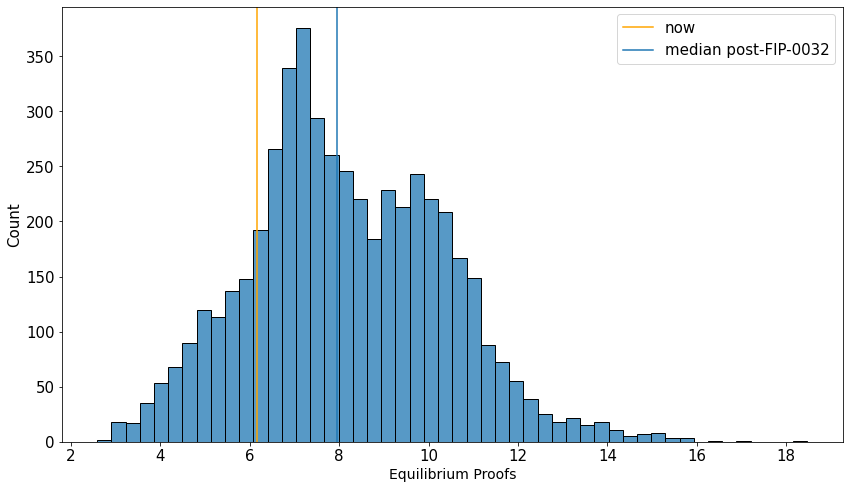

Equilibrium proofs at derived network basefee: 7.96


In [28]:
# Next find the equilibrium number of proofs that correspond to 
# this basefee in the post-FIP-0032 world.
# Equilribium referring to rational batching crossover boundary
n_proofs_samples = breakeven_proofs_at_basefee(derived_network_basefee) # post fIP-0032
n_proofs_samples_now = breakeven_proofs_at_basefee_now(derived_network_basefee) # now
med_equilibrium_proofs = np.median(n_proofs_samples)
med_equilibrium_proofs_now = np.median(n_proofs_samples_now)

plt.xlabel("Equilibrium Proofs", size=14)
plt.axvline(x=med_equilibrium_proofs_now,label='now', color='orange')
plt.axvline(x=med_equilibrium_proofs,label='median post-FIP-0032')
sns.histplot(data=n_proofs_samples, bins=50)
plt.legend()
plt.show()
print(f'Equilibrium proofs at derived network basefee: {round(med_equilibrium_proofs, 2)}')

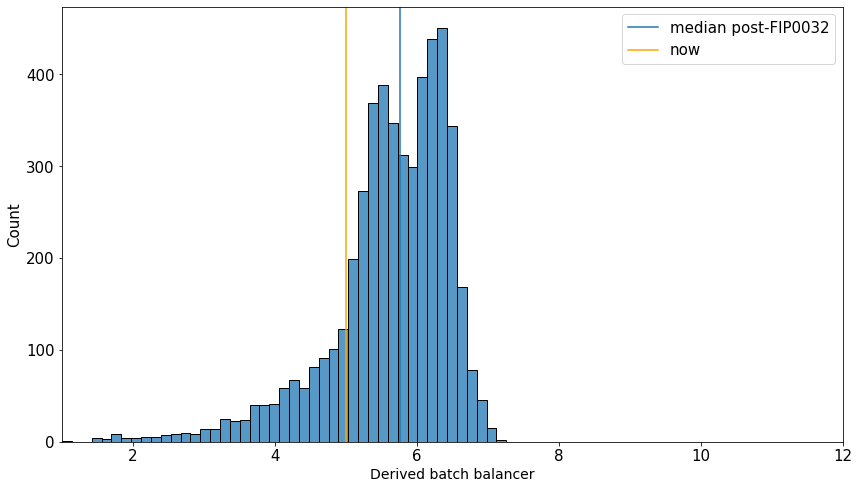

Derived batch balancer:       5.76


In [29]:
# Next find the derived batchbalancer parameter corresponding
# to the equilibrium level of proofs at the derived network
# basefee
def derived_batch_balancer(derived_network_basefee, n_proofs):
    
    top = (derived_network_basefee * (gas_usage_pre_commit_sector + gas_usage_prove_commit_sector) 
           - derived_network_basefee * 
           (reg_pre.predict([[n_proofs]]) + reg_prove.predict([[n_proofs]]))/n_proofs)
    
    bottom = BATCHDISCOUNT * (gas_usage_pre_commit_sector + gas_usage_prove_commit_sector)
    batch_bal = top / bottom
    return round(batch_bal[0],2)

batch_bal_samples = list(map(lambda x: derived_batch_balancer(derived_network_basefee, x), n_proofs_samples))
batch_bal_now = derived_batch_balancer(derived_network_basefee, n_proofs_samples_now)

med_batch_bal_samples  = np.median(batch_bal_samples)
plt.xlabel("Derived batch balancer", size=14)
plt.axvline(x=med_batch_bal_samples,label='median post-FIP0032')
plt.axvline(x=batch_bal_now,label='now', color='orange')
sns.histplot(data=batch_bal_samples, bins=50)
plt.xlim(1,12)
plt.legend()
plt.show()
print(f'Derived batch balancer: \
      {derived_batch_balancer(calculate_derived_network_basefee(DAILY_POWER_GROWTH_PIB), med_equilibrium_proofs)}')

In [30]:
# Not significantly different from the current batchbalancer of 5.
# But how about using the current network fee?

#### 2. Estimate crossover number of proofs and new batch balancer using the *current* netork basefee:

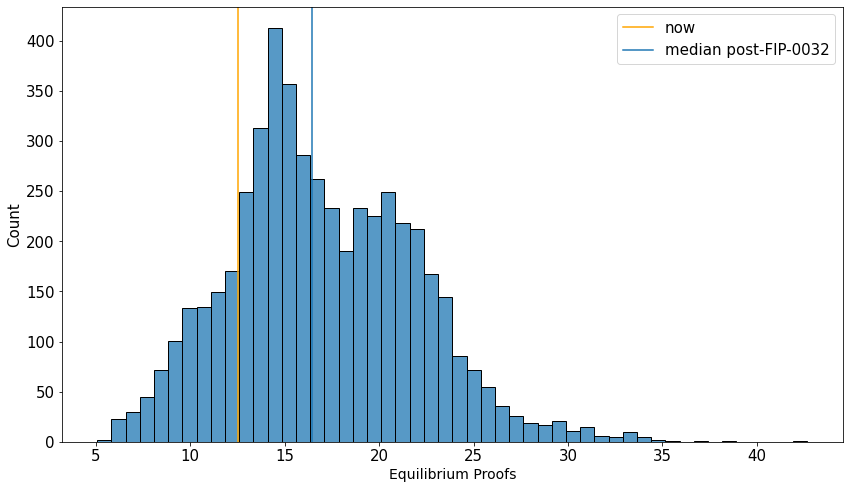

Equilibrium proofs at derived network basefee: 16.44
Equilibrium proofs change at derived network basefee: 3.92
q10, q90:       [-1.63248036 10.77232913]


In [31]:
# What happens at current basefee around 0.32?
n_proofs_samples = breakeven_proofs_at_basefee(CURRENT_BASEFEE) 
n_proofs_samples_now = breakeven_proofs_at_basefee_now(CURRENT_BASEFEE) 
med_equilibrium_proofs = np.median(n_proofs_samples)
med_equilibrium_proofs_now = np.median(n_proofs_samples_now)

plt.xlabel("Equilibrium Proofs", size=14)
plt.axvline(x=med_equilibrium_proofs_now,label='now', color='orange')
plt.axvline(x=med_equilibrium_proofs,label='median post-FIP-0032')
sns.histplot(data=n_proofs_samples, bins=50)
plt.legend()
plt.show()
print(f'Equilibrium proofs at derived network basefee: {round(med_equilibrium_proofs, 2)}')
print(f'Equilibrium proofs change at derived network basefee: {round(med_equilibrium_proofs -med_equilibrium_proofs_now , 2)}')
print(f'q10, q90: \
      {np.quantile(n_proofs_samples - n_proofs_samples_now,[0.1,0.9])}')

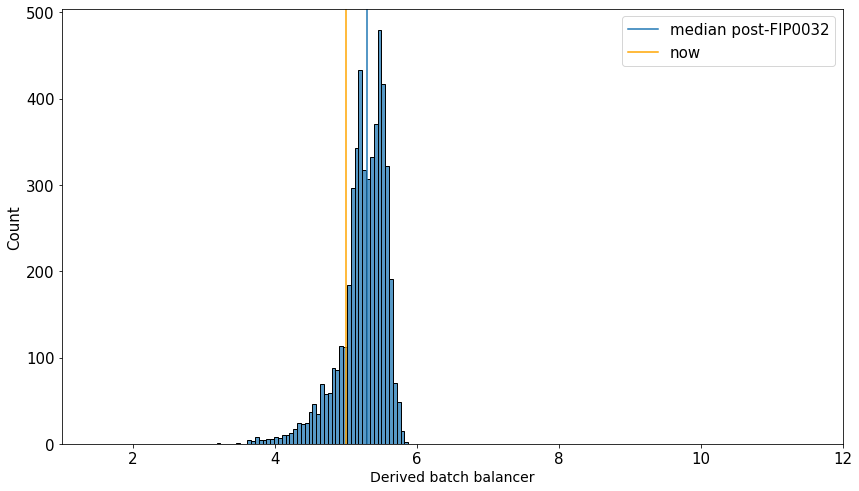

Derived batch balancer:       5.3
q10, q90:       [4.81 5.57]


In [32]:
batch_bal_samples = list(map(lambda x: derived_batch_balancer(CURRENT_BASEFEE, x), n_proofs_samples))
batch_bal_now = derived_batch_balancer(CURRENT_BASEFEE, n_proofs_samples_now)

med_batch_bal_samples  = np.median(batch_bal_samples)
plt.xlabel("Derived batch balancer", size=14)
plt.axvline(x=med_batch_bal_samples,label='median post-FIP0032')
plt.axvline(x=batch_bal_now,label='now', color='orange')
sns.histplot(data=batch_bal_samples, bins=50)
plt.xlim(1,12)
plt.legend()
plt.show()
print(f'Derived batch balancer: \
      {med_batch_bal_samples}')

print(f'q10, q90: \
      {np.quantile(batch_bal_samples,[0.1,0.9])}')

In [33]:
# No substantial change.

## Hypothetical scenarios

In [34]:
# There's significant aleatoric uncertainty arising for
# space of potential gas usage configurations that can be sampled
# in a post-FIP-0032 world. Production may differ further for a
# bunch of reasons, so let's consider a couple of scenarios:

# 1. batch gas multiplers being x2 greater again
# 2. single sector gas multiplers being 2x greater again

In [35]:
breakeven_proofs_at_basefee_now  = lambda bf: breakeven_n_proofs([1, 1, 1, 1], bf)
point_est_mul = multipliers_df.median().values
breakeven_proofs_at_basefee_postFVM = lambda bf: breakeven_n_proofs(point_est_mul, bf)
breakeven_proofs_at_basefee_postFVM_batchx2 = lambda bf: breakeven_n_proofs(point_est_mul*np.array([1,1,2,2]), bf)
breakeven_proofs_at_basefee_postFVM_sectorx2 = lambda bf: breakeven_n_proofs(point_est_mul*np.array([2,2,1,1]), bf)

breakeven_proofs_now = [breakeven_proofs_at_basefee_now(bf) for bf in basefees]
breakeven_proofs_at_basefee_postFVM_list = [breakeven_proofs_at_basefee_postFVM(bf) for bf in basefees]
breakeven_proofs_at_basefee_postFVM_batchx2_list = [breakeven_proofs_at_basefee_postFVM_batchx2(bf) for bf in basefees]
breakeven_proofs_at_basefee_postFVM_sectorx2_list = [breakeven_proofs_at_basefee_postFVM_sectorx2(bf) for bf in basefees]

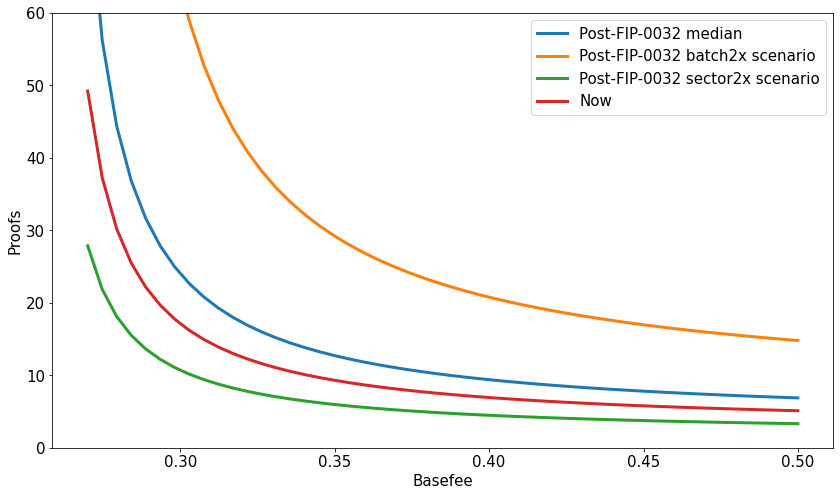

In [36]:
plt.plot(basefees, breakeven_proofs_at_basefee_postFVM_list,lw=3, label="Post-FIP-0032 median")
plt.plot(basefees, breakeven_proofs_at_basefee_postFVM_batchx2_list,lw=3, label="Post-FIP-0032 batch2x scenario")
plt.plot(basefees, breakeven_proofs_at_basefee_postFVM_sectorx2_list,lw=3, label="Post-FIP-0032 sector2x scenario")
plt.plot(basefees, breakeven_proofs_now, lw=3, label="Now")
plt.ylabel('Proofs')
plt.xlabel('Basefee')
plt.ylim(0,60)
plt.legend()
plt.show()

In [37]:
# If the batching multiplers are actually double the test case, that's quite a
# substantial shift
# crossover proofs if batching mulipler is out by 2x compared to now:
np.median(breakeven_proofs_at_basefee_postFVM_batchx2(CURRENT_BASEFEE)), breakeven_proofs_at_basefee_now(CURRENT_BASEFEE)

(41.95797784477449, 12.522673107544323)

In [38]:
# change
np.median(breakeven_proofs_at_basefee_postFVM_batchx2(CURRENT_BASEFEE))-breakeven_proofs_at_basefee_now(CURRENT_BASEFEE)

29.43530473723017

In [39]:
# We should monitor if the backtest multiplers are representative 
# of production, as the above is a fairly large shift in terms of
# who can and can't batch